In [1]:
import os
import boto3
import re
import copy
import time
from time import gmtime, strftime
from sagemaker import get_execution_role

role = get_execution_role()

region = boto3.Session().region_name

bucket='sagemaker062719' # Replace with your s3 bucket name
prefix = 'preds' # Used as part of the path in the bucket where you store data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket) # The URL to access the bucket
key = 'input_data'

## Install Libraries

In [2]:
!pip install keras

    100% |████████████████████████████████| 378kB 24.9MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 25.2MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 25.4MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install -U setuptools

    100% |████████████████████████████████| 583kB 26.4MB/s ta 0:00:01
  Found existing installation: setuptools 39.1.0
    Uninstalling setuptools-39.1.0:
      Successfully uninstalled setuptools-39.1.0
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
!pip install tensorflow-gpu==1.12.0
#----ignore-installed wrapt

    100% |████████████████████████████████| 281.7MB 143kB/s eta 0:00:01   11% |███▊                            | 33.1MB 51.1MB/s eta 0:00:05    32% |██████████▍                     | 91.5MB 49.9MB/s eta 0:00:04    33% |██████████▊                     | 94.0MB 49.6MB/s eta 0:00:04
    100% |████████████████████████████████| 112kB 38.1MB/s ta 0:00:01
    100% |████████████████████████████████| 2.3MB 15.7MB/s ta 0:00:01
    100% |████████████████████████████████| 3.1MB 14.9MB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 24.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for absl-py ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/9a/1e/7a/456008eb5e47fd5de792c6139df6d5b3d5f71d51c6a0b94799
  Running setup.py bdist_wheel for termcolor ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Running setup.py bdist_wheel for gast ... done
  Stored in directory: /home/ec2-user/.cache/pip/whee

In [5]:
!pip install tqdm

    100% |████████████████████████████████| 61kB 22.0MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
!pip install opencv-python

    100% |████████████████████████████████| 28.7MB 1.4MB/s eta 0:00:01
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
!pip install keras-tqdm

You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Preprocess the data set

In [12]:
# import libraries

import numpy as np 
import pandas as pd 
import os
from IPython.display import display 
from time import time
import matplotlib.pyplot as plt
import seaborn as sns 
import cv2
import random
from tqdm import tqdm
from collections import Counter

#import keras 

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras import utils
from sklearn.datasets import load_files   
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import xception
from tensorflow.keras.models import Model
from keras_tqdm import TQDMNotebookCallback

In [2]:
# uploaded zipped local file to the notebook instance and unzipped it

# includes training, test, validation sets for retina images
# training and validation sets are upsampled, test set is not

import zipfile as zf
files = zf.ZipFile("input_data.zip", 'r', allowZip64=True)
files.extractall()
files.close()

In [9]:
# image paths

data_train_path = 'input_data/train'
data_valid_path = 'input_data/validate'
data_test_path = 'input_data/test'

In [ ]:
# double checking counts

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 5)
    return files, targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(data_train_path)
valid_files, valid_targets = load_dataset(data_valid_path)
test_files, test_targets = load_dataset(data_test_path)

# list of cat names
names = ['0','1','2','3','4']

# print statistics about the dataset
print('There are %d total optin categories.' % len(names))
print('There are %s total images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training images.' % len(train_files))
print('There are %d validation images.' % len(valid_files))
print('There are %d test images.'% len(test_files))

## Transfer Learning

In [12]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

## RGB preprocess

In [99]:
train_path_0 = 'input_data/train/0/'
train_path_1 = 'input_data/train/1/'
train_path_2 = 'input_data/train/2/'
train_path_3 = 'input_data/train/3/'
train_path_4 = 'input_data/train/4/'

dst_train_0 = "processed/train_images/0/"
dst_train_1 = "processed/train_images/1/"
dst_train_2 = "processed/train_images/2/"
dst_train_3 = "processed/train_images/3/"
dst_train_4 = "processed/train_images/4/"


for image_name in os.listdir(train_path_0):
    image_path = os.path.join(train_path_0, image_name)
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # crop
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur(image , (0,0) , 10) ,-4 ,128)
    
    
    cv2.imwrite(os.path.join(dst_train_0, image_name), image)
    
    
for image_name in os.listdir(train_path_1):
    image_path = os.path.join(train_path_1, image_name)
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # crop
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur(image , (0,0) , 10) ,-4 ,128)

    cv2.imwrite(os.path.join(dst_train_1, image_name), image)
    
for image_name in os.listdir(train_path_2):
    image_path = os.path.join(train_path_2, image_name)
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # crop
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur(image , (0,0) , 10) ,-4 ,128)
    
    cv2.imwrite(os.path.join(dst_train_2, image_name), image)
    

for image_name in os.listdir(train_path_3):
    image_path = os.path.join(train_path_3, image_name)
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # crop
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur(image , (0,0) , 10) ,-4 ,128)
    
    cv2.imwrite(os.path.join(dst_train_3, image_name), image)
    
    
for image_name in os.listdir(train_path_4):
    image_path = os.path.join(train_path_4, image_name)
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # crop
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur(image , (0,0) , 10) ,-4 ,128)
    
    cv2.imwrite(os.path.join(dst_train_4, image_name), image)


In [100]:
test_path_0 = 'input_data/test/0/'
test_path_1 = 'input_data/test/1/'
test_path_2 = 'input_data/test/2/'
test_path_3 = 'input_data/test/3/'
test_path_4 = 'input_data/test/4/'

dst_test_0 = "processed/test_images/0/"
dst_test_1 = "processed/test_images/1/"
dst_test_2 = "processed/test_images/2/"
dst_test_3 = "processed/test_images/3/"
dst_test_4 = "processed/test_images/4/"


for image_name in os.listdir(test_path_0):
    image_path = os.path.join(test_path_0, image_name)
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # crop
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur(image , (0,0) , 10) ,-4 ,128)
    
    
    cv2.imwrite(os.path.join(dst_test_0, image_name), image)
    

for image_name in os.listdir(test_path_1):
    image_path = os.path.join(test_path_1, image_name)
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # crop
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur(image , (0,0) , 10) ,-4 ,128)

    cv2.imwrite(os.path.join(dst_test_1, image_name), image)
    

for image_name in os.listdir(test_path_2):
    image_path = os.path.join(test_path_2, image_name)
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # crop
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur(image , (0,0) , 10) ,-4 ,128)
    
    cv2.imwrite(os.path.join(dst_test_2, image_name), image)
    

for image_name in os.listdir(test_path_3):
    image_path = os.path.join(test_path_3, image_name)
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # crop
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur(image , (0,0) , 10) ,-4 ,128)
    
    cv2.imwrite(os.path.join(dst_test_3, image_name), image)
    
    
for image_name in os.listdir(test_path_4):
    image_path = os.path.join(test_path_4, image_name)
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # crop
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur(image , (0,0) , 10) ,-4 ,128)
    
    cv2.imwrite(os.path.join(dst_test_4, image_name), image)


In [101]:
valid_path_0 = 'input_data/validate/0/'
valid_path_1 = 'input_data/validate/1/'
valid_path_2 = 'input_data/validate/2/'
valid_path_3 = 'input_data/validate/3/'
valid_path_4 = 'input_data/validate/4/'

dst_valid_0 = "processed/valid_images/0/"
dst_valid_1 = "processed/valid_images/1/"
dst_valid_2 = "processed/valid_images/2/"
dst_valid_3 = "processed/valid_images/3/"
dst_valid_4 = "processed/valid_images/4/"




for image_name in os.listdir(valid_path_0):
    image_path = os.path.join(valid_path_0, image_name)
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # crop
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur(image , (0,0) , 10) ,-4 ,128)
    
    
    cv2.imwrite(os.path.join(dst_valid_0, image_name), image)
    
    
for image_name in os.listdir(valid_path_1):
    image_path = os.path.join(valid_path_1, image_name)
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # crop
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur(image , (0,0) , 10) ,-4 ,128)

    cv2.imwrite(os.path.join(dst_valid_1, image_name), image)
    

for image_name in os.listdir(valid_path_2):
    image_path = os.path.join(valid_path_2, image_name)
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # crop
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur(image , (0,0) , 10) ,-4 ,128)
    
    cv2.imwrite(os.path.join(dst_valid_2, image_name), image)
    

    
for image_name in os.listdir(valid_path_3):
    image_path = os.path.join(valid_path_3, image_name)
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # crop
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur(image , (0,0) , 10) ,-4 ,128)
    
    cv2.imwrite(os.path.join(dst_valid_3, image_name), image)
    
    
for image_name in os.listdir(valid_path_4):
    image_path = os.path.join(valid_path_4, image_name)
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # crop
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted ( image,4, cv2.GaussianBlur(image , (0,0) , 10) ,-4 ,128)
    
    cv2.imwrite(os.path.join(dst_valid_4, image_name), image)


In [97]:
image_path = os.path.join(train_path_0, '04579e31e4be.png')
image = cv2.imread(image_path)

#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # crop
image = crop_image_from_gray(image)
image = cv2.resize(image, (224, 224))
image = cv2.addWeighted ( image,4, cv2.GaussianBlur(image , (0,0) , 10) ,-4 ,128)

#cv2.imwrite('test/test10.png', image)

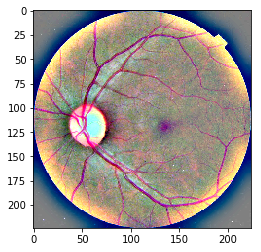

In [98]:
plt.imshow(image)

In [17]:
data_train_path = 'processed/train_images'
data_valid_path = 'processed/valid_images'
data_test_path = 'processed/test_images'


In [18]:
# define image generators
# each image is interpreted as a matrix with 1 entry for each image pixel. i.e. 28x 28 pixels will be a 28x28 matrix
# rescale the images to standardize pixels -- between 0(black) or 1(white)

batch_size = 64

# Transforms
datagen_train = ImageDataGenerator(
    rescale=1./255,
    #include below params for image augmentation, prevents overfitting, model is rotation invariant, etc.
    
    rotation_range=20,
    #zoom_range = 0.2,
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    #shear_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    fill_mode ='nearest')


datagen_valid = ImageDataGenerator(
    rescale=1./255)
    #rotation_range=20,
    #zoom_range = 0.05,
    #width_shift_range=0.1,  # randomly shift images horizontally
    #height_shift_range=0.1,  # randomly shift images vertically
    #shear_range=0.05,
    #horizontal_flip=True)

datagen_test = ImageDataGenerator(
    rescale=1./255)

In [19]:
# define train, valid and test generators, these will feed the above image generators into model

train_generator = datagen_train.flow_from_directory(
        data_train_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

valid_generator = datagen_valid.flow_from_directory(
        data_valid_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)


test_generator = datagen_test.flow_from_directory(
        data_test_path,
        target_size=(224, 224),
        batch_size=1,  # always 1 for test
        class_mode='categorical',
        shuffle=False)

Found 6291 images belonging to 5 classes.
Found 1488 images belonging to 5 classes.
Found 522 images belonging to 5 classes.


In [20]:
num_train = len(train_generator.filenames)
num_valid = len(valid_generator.filenames)
num_test = len(test_generator.filenames)

print(num_train, num_valid, num_test)

6291 1488 522


## Define Architecture

In [23]:
# using ResNet50/ Xception model as the base architecture
# initializing imagenet weights
# imagenet is a project which aims to provide a large image database for research purposes. 
# it contains more than 14 million images which belong to more than 20,000 classes
# include_top = False; can define our own fully connected layer/ change input shape/ create additional nn model to sit on top
base_model = xception.Xception(weights='imagenet', include_top=False)


# add a global average pooling layer
# global avg pooling layers take the 3D feat map array and turn it into a vector
# does this by computing the avg value of each node for each feat map in stack
x = base_model.output
x = GlobalAveragePooling2D()(x)
# alternatively, max avg overlays feats with a window and takes the max value from each
# x = MaxAveragePooling2D()(x)


# Fully-connected layer
# 1024 is number of nodes, to increase accuracy, increase nodes if building model from scratch
# otherwise nodes *may* need to align with above output
#relu i.e. rectified linear function. if + returns value as is, if - returns zero
x = Dense(1024, activation='relu')(x)


# Dropout is a regularization technique patented by Google
# 0.5 means that in each epoch, each node has a 50% probability of being turned off (considered best value for reg)
# prevents overfitting, some nodes may have large weights and dominate the training otherwise

x = Dropout(0.5)(x)



# Logistic layer
# changed dense to 5 and softmax for categorical classification
# returns an array of probabilities for each class, will sum to 1
predictions = Dense(5, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# bc we have large dataset, with very diff pics, need to retrain the network from scratch 
# if pics were similiar, i.e. of animals would set layer.trainable to False
for layer in base_model.layers:
    layer.trainable = True

83689472/83683744 [==============================] - 1s 0us/step


In [24]:
from tensorflow.keras.optimizers import Adam

# compile the model 
# optimizers include:
# SGD (Stochastic Gradient Descent)
# RMSprop (Root Mean Squared Error)
# Adam( Adaptive Moment Estimation)
# calculates an exponential moving average of the gradient and the squared gradient
# parameters beta1 and beta2 control the decay rates of these moving averages

# loss function we use is binary cross entropy, ie Sigmoid Cross-Entropy loss
# Sigmoid activation plus a cross-entropy loss.
# Unlike Softmax loss it is independent for each vector component (class)
# the loss computed for every CNN output vector component is not affected by other component values

# CNN determines what kinds of patterns it needs to detect based on loss function
# In backpropagation step, weights are updated with values that minimize the loss function


#reduced starting lr to .01
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# train the model
# val_loss is the validation loss, this data is NEVER used in training (to backpropagate weights)


# after each epoch, save the weights to path if improved
checkpointer = ModelCheckpoint(filepath='aug9_x_cap_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

# reduce learning rate by factor if loss did not improve after specified patience
scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=4, min_lr=1e-8, verbose=1)

# stop training if loss does not improve after patience
early_stopper = EarlyStopping(monitor='val_loss', patience=10,
                              verbose=0, restore_best_weights=True)

# include class weights below if you want to use it
history = model.fit_generator(train_generator,
                    steps_per_epoch=num_train//batch_size,
                    epochs=15,
                    verbose=0,
                    callbacks=[checkpointer, scheduler, TQDMNotebookCallback(), early_stopper],
                    validation_data=valid_generator,
                    validation_steps=num_valid//batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 00001: val_loss improved from inf to 3.49835, saving model to aug9_x_cap_model.weights.best.hdf5



Epoch 00002: val_loss improved from 3.49835 to 1.95889, saving model to aug9_x_cap_model.weights.best.hdf5



Epoch 00003: val_loss did not improve from 1.95889



Epoch 00004: val_loss did not improve from 1.95889



Epoch 00005: val_loss did not improve from 1.95889



Epoch 00006: val_loss did not improve from 1.95889

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.



Epoch 00007: val_loss did not improve from 1.95889



Epoch 00008: val_loss did not improve from 1.95889



Epoch 00009: val_loss did not improve from 1.95889


KeyboardInterrupt: 

In [25]:
# load the weights that yielded the best validation accuracy

model.load_weights('aug9_x_cap_model.weights.best.hdf5')

In [111]:
test_generator.reset()

In [37]:
# test accuracy

score = model.evaluate_generator(test_generator, steps=num_test//1, verbose=1)
print('\n', 'Test accuracy:', score[1])

522/522 [==============================] - 137s 262ms/step

 Test accuracy: 0.7988505747126436


In [45]:
test_generator.reset()

In [113]:
# softmax returns the probabilities and we take the highest to classify
# however can create custom thresholds as needed


predictions = model.predict_generator(test_generator, steps=num_test)

In [114]:
predicted_classes = np.argmax(predictions, axis=1)

In [115]:
#Confusion Matrix
#get ground truth classes and class labels

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   
class_values = list(test_generator.class_indices.values())
class_dict = dict(test_generator.class_indices)

In [116]:
len(true_classes)

522

In [117]:
print(class_labels)
print(class_values)
print(class_dict)

['0', '1', '2', '3', '4']
[0, 1, 2, 3, 4]
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}


In [40]:
from sklearn import metrics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       249
           1       0.53      0.70      0.60        56
           2       0.78      0.69      0.73       144
           3       0.40      0.30      0.34        27
           4       0.62      0.57      0.59        46

   micro avg       0.80      0.80      0.80       522
   macro avg       0.66      0.65      0.65       522
weighted avg       0.80      0.80      0.80       522



In [25]:
print(metrics.confusion_matrix(true_classes, predicted_classes))

[[246   2   1   0   0]
 [  5  41   9   0   1]
 [  5  24 104   9   2]
 [  0   2  15   7   3]
 [  0   8  12   2  24]]


In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for all classes
y_true = test_generator.classes

y_pred = predicted_classes

cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize confusion matrix
ax = sns.heatmap(cm, annot=True)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

## Deploy Model

In [26]:
import boto3, re
from sagemaker import get_execution_role

role = get_execution_role()

In [28]:
from tensorflow.keras.models import model_from_json

In [29]:
!mkdir keras_model

In [30]:
!ls keras_model

In [31]:
# save model weights
model.save_weights('model_weights.h5')

In [32]:
# save model architecture
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [33]:
json_file = open('model_architecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [34]:
loaded_model.load_weights('aug9_x_cap_model.weights.best.hdf5')
print("Loaded model from disk")

Loaded model from disk


## Export the Keras model to the TensorFlow ProtoBuf format

In [35]:
from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

In [36]:
# Note: This directory structure will need to be followed - see notes for the next section
model_version = '1'
export_dir = 'export/Servo/' + model_version

In [38]:
# Build the Protocol Buffer SavedModel at 'export_dir'
builder = builder.SavedModelBuilder(export_dir)

In [39]:
# Create prediction signature to be used by TensorFlow Serving Predict API
signature = predict_signature_def(
    inputs={"inputs": loaded_model.input}, outputs={"score": loaded_model.output})

In [40]:
from tensorflow.python.keras import backend as K

with K.get_session() as sess:
    sess.run
    # Save the meta graph and variables
    builder.add_meta_graph_and_variables(
        sess=sess, tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
    builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: export/Servo/1/saved_model.pb


## Convert TensorFlow model to a SageMaker readable format

In [41]:
!ls export

Servo


In [42]:
!ls export/Servo

1


In [43]:
!ls export/Servo/1

saved_model.pb	variables


In [44]:
!ls export/Servo/1/variables

variables.data-00000-of-00001  variables.index


### Tar the entire directory and upload to S3

In [45]:
import tarfile
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('export', recursive=True)

In [46]:
import sagemaker

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')

### Deploy the trained model

In [47]:
!touch train.py

In [48]:
from sagemaker.tensorflow.model import TensorFlowModel
sagemaker_model = TensorFlowModel(model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                                  role = role,
                                  framework_version = '1.12',
                                  entry_point = 'train.py')

The Python 2 tensorflow images will be soon deprecated and may not be supported for newer upcoming versions of the tensorflow images.
Please set the argument "py_version='py3'" to use the Python 3 tensorflow image.


In [49]:
## can it work on the cheaper m4?

#%%time
predictor = sagemaker_model.deploy(initial_instance_count=1,
                                   instance_type='ml.m4.xlarge')

---------------------------------------------------------------------------------------------------!

In [50]:
endpoint_name = 'sagemaker-tensorflow-2019-10-04-02-36-23-243'

In [51]:
sagemaker_session = sagemaker.Session()

In [52]:
import sagemaker
from sagemaker.tensorflow.model import TensorFlowModel
predictor=sagemaker.tensorflow.model.TensorFlowPredictor(endpoint_name, sagemaker_session)

In [53]:
data = 'processed/test_images/0/0182152c50de.png'

In [55]:
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(data, target_size=(224,224))
img = image.img_to_array(img)/255
img_expand = np.expand_dims(img, axis=0)

In [56]:
predictor.predict(img_expand)

{'outputs': {'score': {'dtype': 1,
   'tensor_shape': {'dim': [{'size': 1}, {'size': 5}]},
   'float_val': [0.9999792575836182,
    1.7376949472236447e-05,
    3.3062831334973453e-06,
    2.3105459767691627e-09,
    1.018573891897745e-09]}},
 'model_spec': {'name': 'generic_model',
  'version': {'value': 1},
  'signature_name': 'serving_default'}}